# MGTA 613 - Spare Parts

**Adam Ding, Yimeng Zhao**

## Part 1 - Modelling

### Decision Variables
- Let $x_{sdp}$ represent the quantity of units of part $p$ shipped from supplier $s$ to depot $d$.
- Let $y_{cdp}$ represent the quantity of units of part $p$ shipped from depot $d$ to customer $c$.
- Let $z_d$ be a binary variable denoting whether depot $d$ is closed ($z_d = 0$) or open ($z_d = 1$).

### Constraints

#### Supplier

$$
\sum_{d=1}^{19} \sum_{p=1}^{127} x_{sdp} \cdot W_p \leq 200000 \quad \forall s \in \{2, 3, \ldots, 14\}
$$

where $W_p$ represents the weight in kg associated with part $p$.

#### Demand

$$
\sum_{c=1}^{119} \sum_{p=1}^{127} y_{cdp} = D_{pc} \quad \forall d
$$

where $D_{pc}$ represents the demand of part $p$ in units per year from customer $c$.

#### Depot Capacity

$$
\sum_{c=1}^{119} \sum_{p=1}^{127} y_{cdp} \leq
\begin{cases}
    300000 \cdot z_d & \text{if } d = 1 \\
    150000 \cdot \sum_{d=2}^{19} z_d & \text{otherwise}
\end{cases}
$$

#### Parts in = Parts Out

$$
\sum_{p=1}^{127} \sum_{c=1}^{119} y_{cdp} \leq \sum_{p=1}^{127} \sum_{s=1}^{14} x_{sdp}  \quad \forall d
$$

#### Service Level

$$
\sum_{d=1}^{19} S_{cd} \cdot z_d \geq 1 \quad \forall c
$$

where $S_{cd}$ is a binary variable indicating whether customer $c$ is within 9 hours of depot c (1 for "yes" and 0 for "no").

### Objective Function

$$
\text{Minimize } Z = \sum_{d=1}^{19} F_d \cdot z_d +
\sum_{s=1}^{14} \sum_{d=1}^{19} TI_{sd} \cdot \left( \sum_{p=1}^{127} x_{sdp} \cdot W_p \right) +
\sum_{c=1}^{119} \sum_{d=1}^{19} TO_{cd} \cdot \left( \sum_{p=1}^{127} y_{cdp} \cdot W_p \right) 
$$

Where:
- $F_d$ is the fixed cost for opening depot $d$.
- $TI_{sd}$ is the cost in dollars per kilogram transporting from supplier $s$ to depot $d$.
- $TO_{cd}$ is the cost in dollars per kilogram transporting from depot $d$ to customer $c$.
- $W_p$ represents the weight associated with part $p$.


## Part 2 - Solve

In [1]:
# Import required libraries
import gurobipy as gp
from gurobipy import *
import numpy as np
import pandas as pd
import csv

In [2]:
with open('TransCostIn.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    data_list = list(csvreader)
    
TransCostIn = np.array(data_list)
TransCostIn = TransCostIn[1:] # remove first row
# remove first element / change to float
TransCostIn = np.array([[float(entry) for entry in row[1:]] for row in TransCostIn])

In [3]:
with open('TransCost.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    data_list = list(csvreader)
    
TransCost = np.array(data_list)
TransCost = TransCost[1:]
TransCost = np.array([[float(entry) for entry in row[1:]] for row in TransCost])

In [4]:
with open('FixedCost.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    data_list = list(csvreader)
    
FixedCost = np.array(data_list)
FixedCost = FixedCost[:, 1].astype(int)

In [5]:
with open('Demand.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    data_list = list(csvreader)
    
Demand = np.array(data_list)
Demand = Demand[1:]
Demand = np.array([[float(entry) for entry in row[1:]] for row in Demand]) 

In [6]:
with open('Weights.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    data_list = list(csvreader)
    
Weights = np.array(data_list)
Weights = Weights[:, 1].astype(float)

In [7]:
# Constants
suppliers = range(TransCostIn.shape[0])
depots = range(FixedCost.shape[0])
parts = range(Demand.shape[0])
customers = range(Demand.shape[1])

In [8]:
m = Model("SpareParts")

# Decision variables
x = m.addVars(suppliers, depots, parts, vtype=GRB.CONTINUOUS)
y = m.addVars(customers, depots, parts, vtype=GRB.CONTINUOUS)
z = m.addVars(depots, vtype=GRB.BINARY)

# Constraints
# Suppliers
for s in suppliers[1:]:
    m.addConstr(quicksum(x[s,d,p] * Weights[p] for d in depots for p in parts) <= 200000)

# Demand
for c in customers:
    for p in parts:
        m.addConstr(quicksum(y[c,d,p] for d in depots) == Demand[p,c])

# Depot Capacity
for d in depots:
    m.addConstr(quicksum(y[c,d,p] for c in customers for p in parts) <= ((300000 if d == 0 else 150000) * z[d]))

# Single-part Flow (Same Parts in = Same Parts out)
for d in depots:
    for p in parts:
        m.addConstr(quicksum(y[c,d,p] for c in customers) == quicksum(x[s,d,p] for s in suppliers))

# Service Level 
ServiceLevel = (TransCost <= 5).astype(int) # Matrix of 1 and 0 

for c in customers:
    m.addConstr(quicksum(ServiceLevel[c,d] * z[d] for d in depots) >= 1)

# Objective Function
m.setObjective(
    quicksum(FixedCost[d] * z[d] for d in depots) +
    quicksum(TransCostIn[s,d] * quicksum(x[s,d,p] * Weights[p] for p in parts) for s in suppliers for d in depots) +
    quicksum(TransCost[c,d] * quicksum(y[c,d,p] * Weights[p] for p in parts) for c in customers for d in depots),
    GRB.MINIMIZE)

m.update()
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.4.0 23E214)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17677 rows, 320948 columns and 927671 nonzeros
Model fingerprint: 0xe7dffba7
Variable types: 320929 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 2e+05]
Found heuristic solution: objective 1.742094e+07
Presolve removed 12636 rows and 246533 columns
Presolve time: 0.37s
Presolved: 5041 rows, 74415 columns, 194840 nonzeros
Variable types: 74396 continuous, 19 integer (19 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.964

In [9]:
fix = sum(FixedCost[d] * z[d].X for d in depots)
depot_in = quicksum(TransCostIn[s,d] * quicksum(x[s,d,p].X * Weights[p] for p in parts) for s in suppliers for d in depots)
depot_out = quicksum(TransCost[c,d] * quicksum(y[c,d,p].X * Weights[p] for p in parts) for c in customers for d in depots)

In [10]:
print(f"Fixed Cost: {fix / m.objVal * 100}%, ${fix}")
print(f"Varible Transportation Costs: {(depot_in + depot_out) / m.objVal * 100}%, ${depot_in + depot_out}")

Fixed Cost: 30.494588654622873%, $1373222.0
Varible Transportation Costs: 69.5054113453773%, $3129944.170079906


In [11]:
count = 0
open_depots = []

if m.status == gp.GRB.OPTIMAL:
    for d in depots:
        if z[d].X >= 1:
            count += 1
            open_depots.append(f"Depot {d+1}")
    print(f"{count} depots are required.")
    print(f"{open_depots} are the open depots.")
    print("Objective value:", m.objVal)

else:
    print("No optimal solution found.") 

5 depots are required.
['Depot 1', 'Depot 2', 'Depot 4', 'Depot 13', 'Depot 18'] are the open depots.
Objective value: 4503166.170079898


### Methodology

1. **Problem Definition**: Identify the goal to minimize operational and transportation costs while meeting service level requirements.
2. **Data Preparation**: Preprocess data on demand, transportation costs, depot locations, and capacity.
3. **Model Formulation**: Establish decision variables for depot operations and part transportation, define the objective function to minimize costs, and set constraints for service levels, supply limits, demand fulfillment, depot capacity and part consistency.
4. **Implementation in Gurobi**: Load data into Gurobi within Python, and set up the mixed integer programming model with the defined variables, objective function, and constraints.
5. **Model Solution**: Solve the model using Gurobi to find the optimal depot operation and distribution strategy.
6. **Analysis**: Evaluate the solution to determine the optimal depots, distribution routes, and their financial and operational impacts.


### Results & Interpretation 

Open Depots from Optimal Solution:
 - Depot 1
 - Depot 2
 - Depot 4
 - Depot 13
 - Depot 18

Objective Function Value: **4503166.170079898**. This value is the lowest operating cost possible while being able to delivery to every customer within 9 hours (meaning that each customer has a least one depot that ships to them)

**30.49%** (`$1,373,222`) of the objective function value is fixed costs, and **69.51%** (`$3,129,944`) of the objective function value is variable transportation costs.


## Part 3 – Metrics

### Technical Details

In [12]:
m.printStats()


Statistics for model SpareParts:
  Linear constraint matrix    : 17677 Constrs, 320948 Vars, 927671 NZs
  Variable types              : 320929 Continuous,
19 Integer (19 Binary)
  Matrix coefficient range    : [ 1, 300000 ]
  Objective coefficient range : [ 1.18659, 431365 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 0.00366667, 200000 ]


**320948 Variables and 17677 Constraints**

### Important Customers

In [13]:
customers_code = ['AE', 'AF', 'AG', 'AN', 'AO', 'AR', 'AT', 'AU', 'AW', 'BB', 'BD',
                       'BE', 'BF', 'BG', 'BH', 'BR', 'BS', 'BW', 'CA', 'CG', 'CH', 'CK',
                       'CL', 'CN', 'CO', 'CR', 'CV', 'CY', 'CZ', 'DE', 'DK', 'DZ', 'EC',
                       'EE', 'EG', 'ES', 'ET', 'FI', 'FR', 'GA', 'GB', 'GE', 'GR', 'GT', 
                       'GU', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IS', 'IT', 'JM', 
                       'JO', 'JP', 'KE', 'KR', 'KW', 'KY', 'KZ', 'LB', 'LC', 'LU', 'LV', 
                       'LY', 'MA', 'MH', 'MK', 'MO', 'MQ', 'MT', 'MU', 'MV', 'MX', 'MY', 
                       'MZ', 'NG', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PG', 'PH', 'PK', 'PL', 
                       'PR', 'PT', 'QA', 'RO', 'RU', 'RW', 'SA', 'SE', 'SG', 'SI', 'SK', 
                       'SN', 'SZ', 'TD', 'TH', 'TM', 'TN', 'TR', 'TT', 'TW', 'TZ', 'UA', 
                       'UG', 'US', 'UY', 'VE', 'VG', 'VN', 'YE', 'ZA', 'ZM']

stats = []
for c in customers:
    allocated_depots = []
    total_parts, total_weights, total_cost = 0, 0, 0

    for d in depots:
        shipments = sum(y[c, d, p].X for p in parts)
        weights = sum(y[c, d, p].X * Weights[p] for p in parts)
        cost = weights * TransCost[c, d]

        if shipments > 0:
            allocated_depots.append(d + 1)  # Add 1 for one-indexing
            total_parts += shipments
            total_weights += weights
            total_cost += cost

    cc = customers_code[c]
    stats.append({
        'Customer': cc,
        'Allocated Depots': allocated_depots,
        'Total Parts': total_parts,
        'Total Weights (kg)': total_weights,
        'Total Cost ($)': total_cost
    })

stats = pd.DataFrame(stats)
stats.set_index('Customer', inplace=True)

# Sort by 'Total Cost ($)' in descending order
stats = stats.sort_values('Total Parts', ascending=False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(stats)

         Allocated Depots    Total Parts  Total Weights (kg)  Total Cost ($)
Customer                                                                    
US                    [1]  196162.000127       333575.093129   290877.481209
GB                    [2]   79113.540126       124955.151292   212423.757196
CA                    [1]   51890.887593        84692.892480   267798.926021
DE                    [2]   24425.724104        41825.700150    36472.010531
AU                    [4]   15980.449711        26305.216757   124528.896126
JP                   [18]   15250.814190        25320.499471    95863.410997
NL                    [2]   13810.232488        22593.184323    38408.413349
CN                   [18]    5718.675227         9050.649832     7892.166654
NO                   [18]    5289.976771         8482.175824    37889.879408
ES                    [1]    5069.650659         8121.459000    38658.144842
CH                    [2]    4468.401928         7873.203155    13384.445364

### Depot Stats

In [14]:
depot_stats = []
for d in depots:
    cap_percent = sum(y[c,d,p].X for c in customers for p in parts) / (300000 if d == 0 else 150000) * 100
    cap_percent = round(cap_percent, 2)
    
    weight_kg, total_parts = 0, 0
    total_parts = sum(x[s,d,p].X for s in suppliers for p in parts)
    weight_kg = sum(x[s,d,p].X * Weights[p] for s in suppliers for p in parts)
    
    depot_stats.append({
        "Depot": round(d+1, 2),
        "Capacity %": cap_percent,
        "# of Parts": round(total_parts, 2),
        "kg of Parts": round(weight_kg, 2)
    })

depot_stats = pd.DataFrame(depot_stats)
print(depot_stats.to_string(index=False))

 Depot  Capacity %  # of Parts  kg of Parts
     1       87.14   261429.03    440683.15
     2       90.69   136041.46    220724.30
     3        0.00        0.00         0.00
     4       16.91    25363.45     42008.88
     5        0.00        0.00         0.00
     6        0.00        0.00         0.00
     7        0.00        0.00         0.00
     8        0.00        0.00         0.00
     9        0.00        0.00         0.00
    10        0.00        0.00         0.00
    11        0.00        0.00         0.00
    12        0.00        0.00         0.00
    13        3.16     4737.75      8361.37
    14        0.00        0.00         0.00
    15        0.00        0.00         0.00
    16        0.00        0.00         0.00
    17        0.00        0.00         0.00
    18       32.13    48200.52     79612.57
    19        0.00        0.00         0.00


### Depot Sensitivity

In [15]:
depot_sens = []
for d in depots:
    cap_percent = sum(y[c, d, p].X for c in customers for p in parts)*1.2 / (300000 if d == 0 else 150000) * 100
    cap_percent = round(cap_percent, 2)

    depot_sens.append({
        "Depot": d + 1,
        "Capacity %": cap_percent
    })

depot_sens = pd.DataFrame(depot_sens)
print(depot_sens.to_string(index=False))

 Depot  Capacity %
     1      104.57
     2      108.83
     3        0.00
     4       20.29
     5        0.00
     6        0.00
     7        0.00
     8        0.00
     9        0.00
    10        0.00
    11        0.00
    12        0.00
    13        3.79
    14        0.00
    15        0.00
    16        0.00
    17        0.00
    18       38.56
    19        0.00


If we are increasing demand by 20 percent, we are increasing the total amount of parts from each depot by 20%.

Two of the depots would be over capacity meaning that our solution is sensitive and not robust to an increased demand of 20%. 

#### Alternate Solution (Open Another Depot)

In [16]:
m = Model("SparePartsLogistics")

# Decision variables
x = m.addVars(suppliers, depots, parts, vtype=GRB.CONTINUOUS, name="x")
y = m.addVars(customers, depots, parts, vtype=GRB.CONTINUOUS, name="y")
z = m.addVars(depots, vtype=GRB.BINARY, name="z")

# Constraints
for s in suppliers[1:]:
    m.addConstr(quicksum(x[s,d,p] * Weights[p] for d in depots for p in parts) <= 200000)
    
# Demand
for c in customers:
    for p in parts:
        m.addConstr(quicksum(y[c,d,p] for d in depots) == Demand[p,c]*1.2) # increasing demand by 20%

# Depot Capacity
for d in depots:
    m.addConstr(quicksum(y[c,d,p] for c in customers for p in parts) <= 
                ((300000 if d == 0 else 150000) * z[d]))

# Parts in = Parts out
for d in depots:
    for p in parts:
        m.addConstr(quicksum(y[c,d,p] for c in customers) == quicksum(x[s,d,p] for s in suppliers))
        
for c in customers:
    m.addConstr(quicksum(ServiceLevel[c,d] * z[d] for d in depots) >= 1)
    
# Objective Function
m.setObjective(
    quicksum(FixedCost[d] * z[d] for d in depots) +
    quicksum(TransCostIn[s,d] * quicksum(x[s,d,p] * Weights[p] for p in parts) for s in suppliers for d in depots) +
    quicksum(TransCost[c,d] * quicksum(y[c,d,p] * Weights[p] for p in parts) for c in customers for d in depots),
    GRB.MINIMIZE)

m.update()
m.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.4.0 23E214)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17677 rows, 320948 columns and 927671 nonzeros
Model fingerprint: 0xf8f3f7bc
Variable types: 320929 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 2e+05]
Found heuristic solution: objective 1.969901e+07
Presolve removed 12636 rows and 246533 columns
Presolve time: 0.38s
Presolved: 5041 rows, 74415 columns, 194840 nonzeros
Variable types: 74396 continuous, 19 integer (19 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.605529e+06, 5108 iterations, 0.14 seconds (0.14 work units)

    Nodes    |    Current Node   

In [17]:
depot_sens = []
for d in depots:
    cap_percent = sum(y[c, d, p].X for c in customers for p in parts) / (300000 if d == 0 else 150000) * 100
    cap_percent = round(cap_percent, 2)

    depot_sens.append({
        "Depot": d + 1,
        "Capacity %": cap_percent
    })

depot_sens = pd.DataFrame(depot_sens)
print(depot_sens.to_string(index=False))

 Depot  Capacity %
     1      100.00
     2       49.11
     3        0.00
     4       19.44
     5        0.00
     6        0.00
     7        0.00
     8        0.00
     9        0.00
    10        0.00
    11        0.00
    12        0.00
    13        5.52
    14        0.00
    15        0.00
    16        0.00
    17       79.27
    18       27.27
    19        0.00


Opening Linwood is the most optimal solution to accommodate the increase in demand by 20%. 

## Part 4 – Service Level Sensitivity

### 6H Flight Time Rule ($4.50)

In [18]:
m = Model("SparePartsLogistics")

# Decision variables
x = m.addVars(suppliers, depots, parts, vtype=GRB.CONTINUOUS, name="x")
y = m.addVars(customers, depots, parts, vtype=GRB.CONTINUOUS, name="y")
z = m.addVars(depots, vtype=GRB.BINARY, name="z")

service_level = (TransCost <= 4.5).astype(int)

# Constraints
m.addConstrs((quicksum(x[s,d,p] * Weights[p] for d in depots for p in parts) <= 200000)for s in suppliers[1:])
m.addConstrs((quicksum(y[c,d,p]for d in depots) == Demand[p,c])for c in customers for p in parts)
m.addConstrs((quicksum(y[c,d,p] for c in customers for p in parts) <= 
                ((300000 if d == 0 else 150000) * z[d]))for d in depots)
m.addConstrs((quicksum(y[c,d,p] for c in customers) <= quicksum(x[s,d,p] for s in suppliers))
             for d in depots for p in parts)        
m.addConstrs((quicksum(service_level[c,d] * z[d] for d in depots) >= 1) for c in customers)
    
# Objective Function
m.setObjective(
    quicksum(FixedCost[d] * z[d] for d in depots) +
    quicksum(TransCostIn[s,d] * quicksum(x[s,d,p] * Weights[p] for p in parts) for s in suppliers for d in depots) +
    quicksum(TransCost[c,d] * quicksum(y[c,d,p] * Weights[p] for p in parts) for c in customers for d in depots),
    GRB.MINIMIZE)

m.update()
m.optimize()

count = 0
open_depots = []

if m.status == gp.GRB.OPTIMAL:
    for d in depots:
        if z[d].X >= 1:
            count += 1
            open_depots.append(f"Depot {d+1}")
    print(f"{count} depots are required.")
    print(f"{open_depots} are the open depots.")
    print("Objective value:", m.objVal)

else:
    print("No optimal solution found.") 

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.4.0 23E214)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17677 rows, 320948 columns and 927286 nonzeros
Model fingerprint: 0x0af7b0de
Variable types: 320929 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 2e+05]
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.03 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
No optimal solution found.


### 6.33H Flight Time Rule ($4.555)

In [19]:
m = Model("SparePartsLogistics")

# Decision variables
x = m.addVars(suppliers, depots, parts, vtype=GRB.CONTINUOUS, name="x")
y = m.addVars(customers, depots, parts, vtype=GRB.CONTINUOUS, name="y")
z = m.addVars(depots, vtype=GRB.BINARY, name="z")

service_level = (TransCost <= 4.555).astype(int)

# Constraints
m.addConstrs((quicksum(x[s,d,p] * Weights[p] for d in depots for p in parts) <= 200000)for s in suppliers[1:])
m.addConstrs((quicksum(y[c,d,p]for d in depots) == Demand[p,c])for c in customers for p in parts)
m.addConstrs((quicksum(y[c,d,p] for c in customers for p in parts) <= 
                ((300000 if d == 0 else 150000) * z[d]))for d in depots)
m.addConstrs((quicksum(y[c,d,p] for c in customers) <= quicksum(x[s,d,p] for s in suppliers))
             for d in depots for p in parts)        
m.addConstrs((quicksum(service_level[c,d] * z[d] for d in depots) >= 1) for c in customers)
    
# Objective Function
m.setObjective(
    quicksum(FixedCost[d] * z[d] for d in depots) +
    quicksum(TransCostIn[s,d] * quicksum(x[s,d,p] * Weights[p] for p in parts) for s in suppliers for d in depots) +
    quicksum(TransCost[c,d] * quicksum(y[c,d,p] * Weights[p] for p in parts) for c in customers for d in depots),
    GRB.MINIMIZE)

m.update()
m.optimize()

count = 0
open_depots = []

if m.status == gp.GRB.OPTIMAL:
    for d in depots:
        if z[d].X >= 1:
            count += 1
            open_depots.append(f"Depot {d+1}")
    print(f"{count} depots are required.")
    print(f"{open_depots} are the open depots.")
    print("Objective value:", m.objVal)

else:
    print("No optimal solution found.") 

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.4.0 23E214)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17677 rows, 320948 columns and 927359 nonzeros
Model fingerprint: 0x6e930927
Variable types: 320929 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 2e+05]
Found heuristic solution: objective 1.789736e+07
Presolve removed 12624 rows and 246239 columns
Presolve time: 0.42s
Presolved: 5053 rows, 74709 columns, 195106 nonzeros
Variable types: 74692 continuous, 17 integer (17 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.412991e+06, 5672 iterations, 0.15 seconds (0.16 work units)

    Nodes    |    Current Node   

### 9H Flight Time Rule ($5.00)

In [20]:
m = Model("SparePartsLogistics")

# Decision variables
x = m.addVars(suppliers, depots, parts, vtype=GRB.CONTINUOUS, name="x")
y = m.addVars(customers, depots, parts, vtype=GRB.CONTINUOUS, name="y")
z = m.addVars(depots, vtype=GRB.BINARY, name="z")

service_level = (TransCost <= 5).astype(int)

# Constraints
m.addConstrs((quicksum(x[s,d,p] * Weights[p] for d in depots for p in parts) <= 200000)for s in suppliers[1:])
m.addConstrs((quicksum(y[c,d,p]for d in depots) == Demand[p,c])for c in customers for p in parts)
m.addConstrs((quicksum(y[c,d,p] for c in customers for p in parts) <= 
                ((300000 if d == 0 else 150000) * z[d]))for d in depots)
m.addConstrs((quicksum(y[c,d,p] for c in customers) <= quicksum(x[s,d,p] for s in suppliers))
             for d in depots for p in parts)        
m.addConstrs((quicksum(service_level[c,d] * z[d] for d in depots) >= 1) for c in customers)
    
# Objective Function
m.setObjective(
    quicksum(FixedCost[d] * z[d] for d in depots) +
    quicksum(TransCostIn[s,d] * quicksum(x[s,d,p] * Weights[p] for p in parts) for s in suppliers for d in depots) +
    quicksum(TransCost[c,d] * quicksum(y[c,d,p] * Weights[p] for p in parts) for c in customers for d in depots),
    GRB.MINIMIZE)

m.update()
m.optimize()

count = 0
open_depots = []

if m.status == gp.GRB.OPTIMAL:
    for d in depots:
        if z[d].X >= 1:
            count += 1
            open_depots.append(f"Depot {d+1}")
    print(f"{count} depots are required.")
    print(f"{open_depots} are the open depots.")
    print("Objective value:", m.objVal)

else:
    print("No optimal solution found.") 

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.4.0 23E214)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17677 rows, 320948 columns and 927671 nonzeros
Model fingerprint: 0xa7b0f94c
Variable types: 320929 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 2e+05]
Found heuristic solution: objective 1.789736e+07
Presolve removed 12620 rows and 246237 columns
Presolve time: 0.42s
Presolved: 5057 rows, 74711 columns, 195136 nonzeros
Variable types: 74692 continuous, 19 integer (19 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 3.964688e+06, 5500 iterations, 0.15 seconds (0.15 work units)

    Nodes    |    Current Node   

### 12H Flight Time Rule ($5.50)

In [21]:
m = Model("SparePartsLogistics")

# Decision variables
x = m.addVars(suppliers, depots, parts, vtype=GRB.CONTINUOUS, name="x")
y = m.addVars(customers, depots, parts, vtype=GRB.CONTINUOUS, name="y")
z = m.addVars(depots, vtype=GRB.BINARY, name="z")

service_level = (TransCost <= 5.5).astype(int)

# Constraints
m.addConstrs((quicksum(x[s,d,p] * Weights[p] for d in depots for p in parts) <= 200000)for s in suppliers[1:])
m.addConstrs((quicksum(y[c,d,p]for d in depots) == Demand[p,c])for c in customers for p in parts)
m.addConstrs((quicksum(y[c,d,p] for c in customers for p in parts) <= 
                ((300000 if d == 0 else 150000) * z[d]))for d in depots)
m.addConstrs((quicksum(y[c,d,p] for c in customers) <= quicksum(x[s,d,p] for s in suppliers))
             for d in depots for p in parts)        
m.addConstrs((quicksum(service_level[c,d] * z[d] for d in depots) >= 1) for c in customers)
    
# Objective Function
m.setObjective(
    quicksum(FixedCost[d] * z[d] for d in depots) +
    quicksum(TransCostIn[s,d] * quicksum(x[s,d,p] * Weights[p] for p in parts) for s in suppliers for d in depots) +
    quicksum(TransCost[c,d] * quicksum(y[c,d,p] * Weights[p] for p in parts) for c in customers for d in depots),
    GRB.MINIMIZE)

m.update()
m.optimize()

count = 0
open_depots = []

if m.status == gp.GRB.OPTIMAL:
    for d in depots:
        if z[d].X >= 1:
            count += 1
            open_depots.append(f"Depot {d+1}")
    print(f"{count} depots are required.")
    print(f"{open_depots} are the open depots.")
    print("Objective value:", m.objVal)

else:
    print("No optimal solution found.") 


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.4.0 23E214)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17677 rows, 320948 columns and 927987 nonzeros
Model fingerprint: 0x721adecc
Variable types: 320929 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 2e+05]
Found heuristic solution: objective 1.789736e+07
Presolve removed 12620 rows and 246237 columns
Presolve time: 0.44s
Presolved: 5057 rows, 74711 columns, 195170 nonzeros
Variable types: 74692 continuous, 19 integer (19 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 3.589842e+06, 5773 iterations, 0.18 seconds (0.17 work units)

    Nodes    |    Current Node   

### 15H Flight Time Rule ($6.00)

In [22]:
m = Model("SparePartsLogistics")

# Decision variables
x = m.addVars(suppliers, depots, parts, vtype=GRB.CONTINUOUS, name="x")
y = m.addVars(customers, depots, parts, vtype=GRB.CONTINUOUS, name="y")
z = m.addVars(depots, vtype=GRB.BINARY, name="z")

service_level = (TransCost <= 6).astype(int)

# Constraints
m.addConstrs((quicksum(x[s,d,p] * Weights[p] for d in depots for p in parts) <= 200000)for s in suppliers[1:])
m.addConstrs((quicksum(y[c,d,p]for d in depots) == Demand[p,c])for c in customers for p in parts)
m.addConstrs((quicksum(y[c,d,p] for c in customers for p in parts) <= 
                ((300000 if d == 0 else 150000) * z[d]))for d in depots)
m.addConstrs((quicksum(y[c,d,p] for c in customers) <= quicksum(x[s,d,p] for s in suppliers))
             for d in depots for p in parts)        
m.addConstrs((quicksum(service_level[c,d] * z[d] for d in depots) >= 1) for c in customers)
    
# Objective Function
m.setObjective(
    quicksum(FixedCost[d] * z[d] for d in depots) +
    quicksum(TransCostIn[s,d] * quicksum(x[s,d,p] * Weights[p] for p in parts) for s in suppliers for d in depots) +
    quicksum(TransCost[c,d] * quicksum(y[c,d,p] * Weights[p] for p in parts) for c in customers for d in depots),
    GRB.MINIMIZE)

m.update()
m.optimize()

count = 0
open_depots = []

if m.status == gp.GRB.OPTIMAL:
    for d in depots:
        if z[d].X >= 1:
            count += 1
            open_depots.append(f"Depot {d+1}")
    print(f"{count} depots are required.")
    print(f"{open_depots} are the open depots.")
    print("Objective value:", m.objVal)

else:
    print("No optimal solution found.") 


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.4.0 23E214)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17677 rows, 320948 columns and 928353 nonzeros
Model fingerprint: 0x58e379bf
Variable types: 320929 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 2e+05]
Found heuristic solution: objective 1.789736e+07
Presolve removed 12621 rows and 246237 columns
Presolve time: 0.44s
Presolved: 5056 rows, 74711 columns, 195207 nonzeros
Variable types: 74692 continuous, 19 integer (19 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 3.490936e+06, 5893 iterations, 0.16 seconds (0.15 work units)

    Nodes    |    Current Node   

### Formulation

For setting the flight time rule, each model creates a new binary matrix of 0 and 1 based on the cost proxy. 1 denotes that the customer is within the flight time rule whereas 0 denotes that the customer is not within the flight time rule.

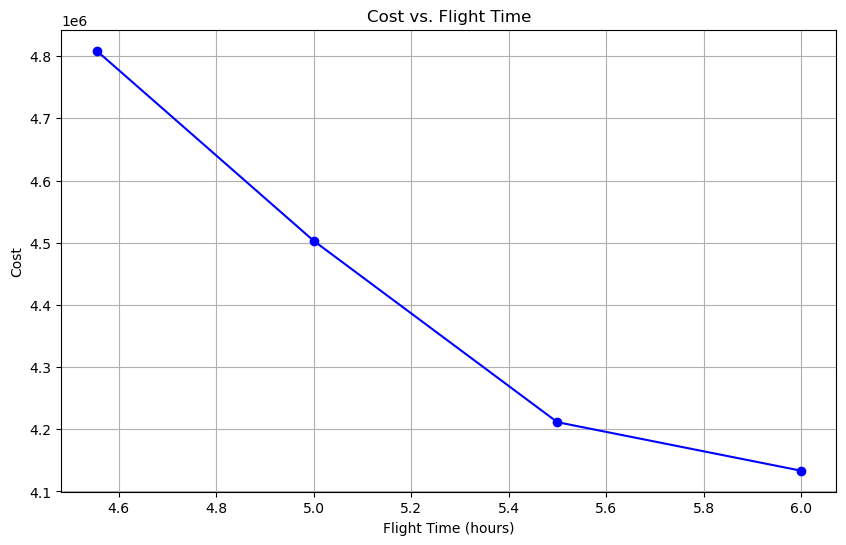

In [23]:
import matplotlib.pyplot as plt

flight_time = [4.5,4.555, 5, 5.5, 6]
cost = [np.nan,4808728.99, 4503166.17, 4211389.37, 4133330.27]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(flight_time, cost, marker='o', linestyle='-', color='blue')
plt.title('Cost vs. Flight Time')
plt.xlabel('Flight Time (hours)')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

### Recommendation

Our recommendation is to use the 9-hour flight time rule as it provides the best balance between customer satisfaction (delivery speed) and depot operation cost. Evaluating the cost per hour change, we determined that transitioning from 6.33 hours to 9 hours is more efficient than extending from 9 hours to 12 hours. Therefore, based on hourly savings, the 9-hour rule emerges as the most optimal choice. Moreover, implementing this flight time rule not only ensures cost-effectiveness but also contributes to improved customer satisfaction and a competitive advantage in the market, making operations more efficient overall.